# LEQ mismatch from using fixed tune (6.21, 6.24) distribution

In [66]:
import imageio
import numpy as np
import PyNAFF as pnf
import scipy.io as sio 
import matplotlib.cm as cm
from math import log10, floor
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit

In [67]:
plt.rcParams['figure.figsize'] = [8.0, 4.0]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1

## Function Definitions

### Betatronic Mismatch on Bunch

In [68]:
def emittance_beta_mismatch(eps_0, beta_1, beta_2, alpha_1, alpha_2):
    return ((eps_0 / 2) * ( (beta_1 / beta_2) + (beta_2/beta_1) + (beta_2 / beta_1)*(alpha_1 - alpha_2*(beta_1/beta_2))**2 ))

In [69]:
def beta_beating_from_single_quad(delta_k):
    return delta_k / 0.0510425 

In [70]:
def tuneshift_from_quad_error(delta_k, beta_max):
    return ((delta_k * beta_max) / (4 * np.pi))

In [71]:
def round_sig(x, sig=4):
    return round(x, sig-int(floor(log10(abs(x))))-1)

### TFS Table helpers

In [72]:
def PTC_TWISS_Header_Line_Finder(tfs_file, verbose = True):
    test = open(tfs_file, 'r')

    test_lines = test.readlines()
    header_lines = -1
    for l in test_lines:
        header_lines = header_lines + 1
        if '*' in l.split()[0]:
            if verbose: print 'Header end located on line ', header_lines, ':'
            if verbose: print l
            break
    return header_lines

## Load data from TFS tables for LEQ optics

In [73]:
LEQ_Twiss_Files = []

LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_10/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_11/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_12/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_13/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_14/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_15/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_16/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_17/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_18/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_19/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_20/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_21/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_22/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_23/optimised_leq_final_v_again.tfs')
LEQ_Twiss_Files.append('../00_Flat_Files/Optimised_Lattice/Flat_Files/V_21_24/optimised_leq_final_v_again.tfs')

print 'First file Qx = ', LEQ_Twiss_Files[0][48:50], ', Qy = ', LEQ_Twiss_Files[0][51:53]

First file Qx =  21 , Qy =  10


### Create a dictionary to hold all data

In [74]:
# Top level dictionary
LEQ_TWISS = dict()
first_pass = True
pc = dict() # parameter conversion dictionary shows which column is which variable
cp = dict() # reverse of above
v = 0

for fi in LEQ_Twiss_Files:
        
    # First level dictionary: Key = vertical tune
    LEQ_TWISS[fi[51:53]] = dict()
    
    # Open and read file
    f = open(fi, 'r')
    lines = f.readlines()[PTC_TWISS_Header_Line_Finder(fi, False):]
    
    # create dictionary from keywords on first pass only
    if first_pass:
        for keyword in lines[0].split():
            if keyword is '*':
                continue
            else:
                cp[keyword] = v
                pc[v] = keyword
                LEQ_TWISS[fi[51:53]][keyword] = 0.0
                v = v + 1
            first_pass = False
        print 'Parameter Map:', pc.keys(), pc.values()

    # Add dictionary items for each element
    m = 0
    el_no = 0
    
    # Add values line by line
    for l in lines[2:]:
        
        # Second level dictionary - by element number
        LEQ_TWISS[fi[51:53]][el_no] = dict()
        
        # Iterate over variables in the line
        m = 0        
        for variable in l.split():
            # Third level dictionary - variable and value
            # Append values according to the parameter converter
            if m is 0:
                # Remove " " from element name - enter as string
                LEQ_TWISS[fi[51:53]][el_no][pc[m]] = variable[1:-1]
            else: # save numbers as floats
                LEQ_TWISS[fi[51:53]][el_no][pc[m]] = float(variable)
            m = m + 1
            
        # increment element number
        el_no = el_no +1
            

Parameter Map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] ['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP3', 'X', 'PX', 'Y', 'PY']


In [77]:
LEQ_TWISS['10'][0]

{'ALFX': 0.0006651703515,
 'ALFY': -0.01751106773,
 'BETX': 12.3917987,
 'BETY': 23.63758073,
 'DISP1': 2.656001885,
 'DISP3': 0.0,
 'NAME': 'PR.BWSV64',
 'PX': 0.0,
 'PY': 0.0,
 'S': 0.0,
 'X': 0.0,
 'Y': 0.0}

In [78]:
LEQ_TWISS['24'][0]

{'ALFX': -0.009295497208,
 'ALFY': 0.04008717362,
 'BETX': 12.56237852,
 'BETY': 21.9292783,
 'DISP1': 2.587645646,
 'DISP3': 0.0,
 'NAME': 'PR.BWSV64',
 'PX': 0.0,
 'PY': 0.0,
 'S': 0.0,
 'X': 0.0,
 'Y': 0.0}

### Make some simple arrays for plotting Analytical expectations

In [79]:
Qy = []
beta_y = []
alpha_y = []

for k, v in sorted(LEQ_TWISS.items()):
    Qy.append(int(k))
    beta_y.append(v[0]['BETY'])
    alpha_y.append(v[0]['ALFY'])
    
# Remove the last element as we don't want to have beta 1 = beta 2 etc
Qy = Qy[:-1]
beta_y = beta_y[:-1]
alpha_y = alpha_y[:-1]

print Qy  

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


### Calculate analytical estimate for emittance growth

0.452525
0.300792
0.20088
0.134214
0.0893233
0.0589328
0.0383252
0.0243854
0.0150249
0.00882622
0.00481821
0.0023304
0.000897587
0.000195965


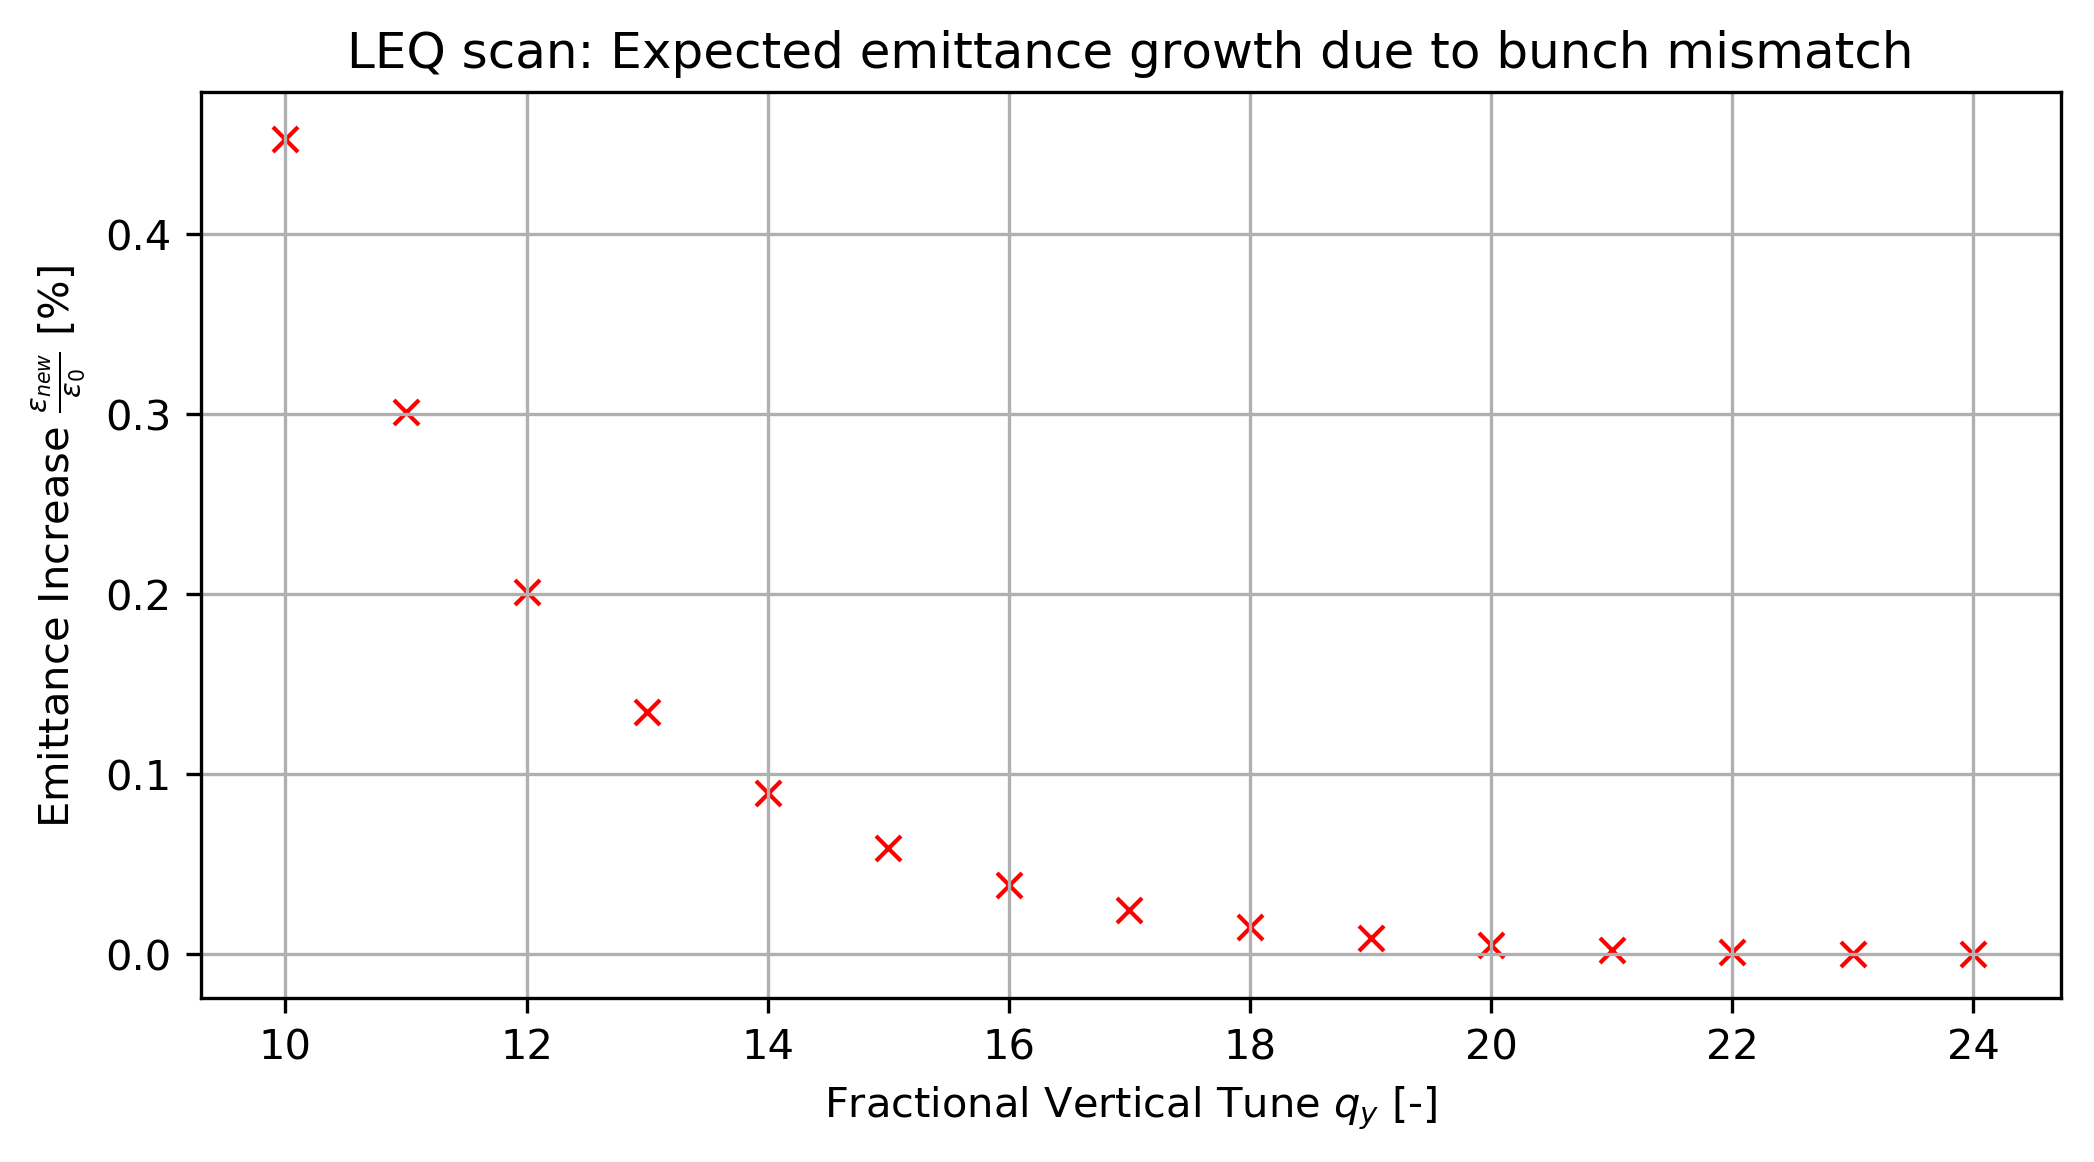

In [83]:
eps_0 = 1.2E-6
beta_1 = LEQ_TWISS['24'][0]['BETY']
alpha_1 = LEQ_TWISS['24'][0]['ALFY']
emittance_factors = []

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 'LEQ scan: Expected emittance growth due to bunch mismatch'
ax1.set_title(tit);

ax1.set_ylabel(r'Emittance Increase $\frac{\epsilon_{new}}{\epsilon_0}$ [%]');
ax1.set_xlabel(r'Fractional Vertical Tune $q_y$ [-]');

for i in range(0,len(Qy)):
    beta_2 = LEQ_TWISS[str(Qy[i])][0]['BETY']
    alpha_2 = LEQ_TWISS[str(Qy[i])][0]['ALFY']
    eps_new = emittance_beta_mismatch(eps_0, beta_1, beta_2, alpha_1, alpha_2)
    print round_sig((eps_new/eps_0)*100-100, 6)
    #emittance_factors.append(round_sig((eps_new/eps_0)*100-100, 4))
    ax1.scatter(Qy[i], round_sig((eps_new/eps_0)*100-100, 4), marker='x', color='r');     
    #print i

# Manually add matched bunch
ax1.scatter(24, 0, marker='x', color='r');     
    
start = 1.01
stop = 2
step = 0.001
mismatch_factors = np.arange(start, stop+step, step)

#ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Test.png'
plt.savefig(savename, dpi = 800);

# Test for mismatch factors of 1.1, 1.1

In [14]:
# Vertical parameters from PFW optics (6.21, 6.10)

beta_mismatch = 1.1
alpha_mismatch = 1.1

eps_0 = 1.2E-6
beta_1 = 22.422
beta_2 = beta_1 * beta_mismatch
alpha_1 = 0.052076
alpha_2 = alpha_1 * alpha_mismatch

eps_new = emittance_beta_mismatch(eps_0, beta_1, beta_2, alpha_1, alpha_2)
print 'Beta mismatch factor = ', beta_mismatch
print 'Alpha mismatch factor = ', alpha_mismatch
print 'Resulting emittance increase = ', round_sig((eps_new/eps_0)*100-100, 2), '%'

Beta mismatch factor =  1.1
Alpha mismatch factor =  1.1
Resulting emittance increase =  0.45 %


# Create a range of mismatch factors and plot resulting expected emittance growth

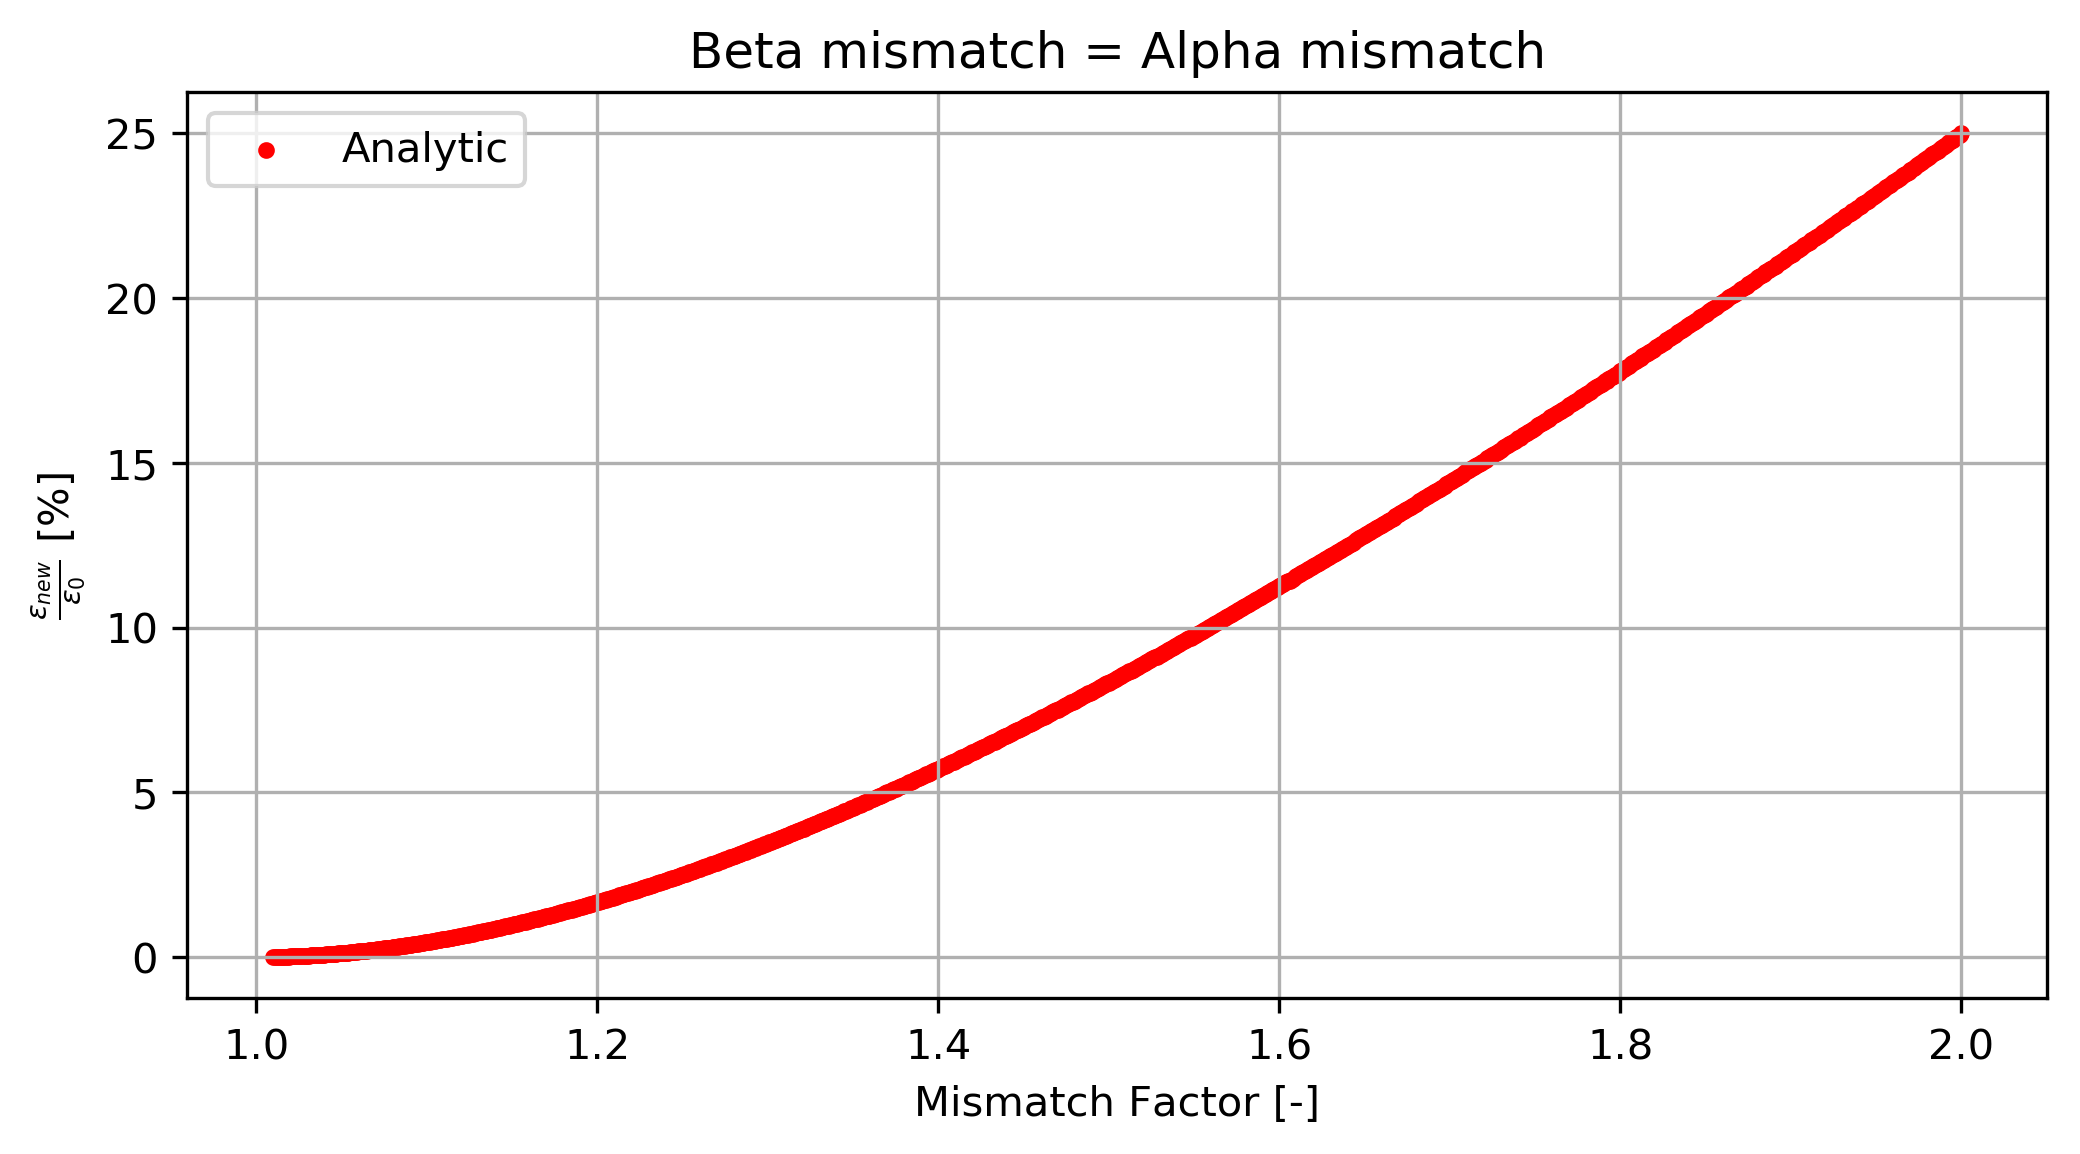

In [15]:
start = 1.01
stop = 2
step = 0.001
mismatch_factors = np.arange(start, stop+step, step)

emittance_factors = []

eps_0 = 1.2E-6
beta_1 = 22.422
alpha_1 = 0.052076

for m in mismatch_factors:
    #print m
    beta_2 = beta_1 * m
    alpha_2 = alpha_1 * m
    eps_new = emittance_beta_mismatch(eps_0, beta_1, beta_2, alpha_1, alpha_2)
    emittance_factors.append(round_sig((eps_new/eps_0)*100-100, 4))

#emittance_factors  

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 'Beta mismatch = Alpha mismatch'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\epsilon_{new}}{\epsilon_0}$ [%]');
ax1.set_xlabel('Mismatch Factor [-]');

ax1.scatter(mismatch_factors, emittance_factors, marker='.', color='r', label='Analytic');     
ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Alpha_1_times_beta.png'
plt.savefig(savename, dpi = 800);

In [ ]:
start = 1.01
stop = 2
step = 0.001
mismatch_factors = np.arange(start, stop+step, step)
sm = np.ones(len(sim_y))*5

emittance_factors = []


sim_x =[1.221, 1.277, 1.326, 1.371, 1.559, 1.718, 1.864, 2.0]
# Calculated mismatch factors give percentages[2, 3, 4, 5, 10, 15, 20, 25]
sim_y = [1.96, 2.96, 3.99, 5.03, 9.99, 14.97, 20.2, 25.09]


sim_sc_x =[1.152, 1.221, 1.277, 1.326, 1.371, 1.559, 1.718, 1.864, 2.0]
sim_sc_y = [0.73, 1.68, 2.59, 3.54, 4.42, 9.28, 13.76, 18.93, 23.54]
sas = np.ones(len(sim_y))*100

eps_0 = 1.2E-6
beta_1 = 22.422
alpha_1 = 0.052076

for m in mismatch_factors:
    #print m
    beta_2 = beta_1 * m
    alpha_2 = alpha_1 * m
    eps_new = emittance_beta_mismatch(eps_0, beta_1, beta_2, alpha_1, alpha_2)
    emittance_factors.append(round_sig((eps_new/eps_0)*100-100, 4))

#emittance_factors  

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 'Beta mismatch = Alpha mismatch'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\epsilon_{new}}{\epsilon_0}$ [%]');
ax1.set_xlabel('Mismatch Factor [-]');

ax1.scatter(mismatch_factors, emittance_factors, marker='.', color='k', label='Analytic', s=sm);     
ax1.scatter(sim_x, sim_y, color='b', marker='x', label='Simulation No Space Charge', s=sas)  
ax1.scatter(sim_sc_x, sim_sc_y, color='r', marker='x', label='Simulation with Space Charge', s=sas)
ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Alpha_1_times_beta_with_data.png'
plt.savefig(savename, dpi = 800);

In [ ]:
n = 142
print round_sig(emittance_factors[n], 3), '%  emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 211
print round_sig(emittance_factors[n], 3), '%  emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 267
print round_sig(emittance_factors[n], 3), '%  emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 316
print round_sig(emittance_factors[n], 3), '% emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 361
print round_sig(emittance_factors[n], 3), '% emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 549
print round_sig(emittance_factors[n], 3), '% emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 708
print round_sig(emittance_factors[n], 3), '% emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 854
print round_sig(emittance_factors[n], 3), '% emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])

n = 990
print round_sig(emittance_factors[n], 3), '% emittance growth given by a mismatch factor of', round_sig(mismatch_factors[n])


# Estimated tunespreads for these mismatches

In [ ]:
start = 1.01
stop = 2
step = 0.001
mismatch_factors = np.arange(start, stop+step, step)

tunespreads = []

beta_max = 23.01757

for m in mismatch_factors:
    delta_Q = tunespread_from_quad_error(m, )
    tunespreads.append(round_sig(delta_Q))

#emittance_factors  

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 'Beta mismatch = Alpha mismatch'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\epsilon_{new}}{\epsilon_0}$ [%]');
ax1.set_xlabel('Mismatch Factor [-]');

ax1.scatter(mismatch_factors, emittance_factors, marker='.', color='r', label='Analytic');     
ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Alpha_1_times_beta.png'
plt.savefig(savename, dpi = 800);

# Alpha mismatch = 5 * Beta mismatch

In [ ]:
start = 1.01
stop = 2
step = 0.01
mismatch_factors = np.arange(start, stop+step, step)

emittance_factors = []

eps_0 = 1.2E-6
beta_1 = 22.422
alpha_1 = 0.052076

for m in mismatch_factors:
    #print m
    beta_2 = beta_1 * m
    alpha_2 = alpha_1 * 5 * m
    eps_new = emittance_beta_mismatch(eps_0, beta_1, beta_2, alpha_1, alpha_2)
    emittance_factors.append(round_sig((eps_new/eps_0)*100-100, 4))

#emittance_factors  

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 'Alpha mismatch = 5 * Beta mismatch'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\epsilon_{new}}{\epsilon_0}$ [%]');
ax1.set_xlabel('Mismatch Factor [-]');

ax1.scatter(mismatch_factors, emittance_factors, marker='.', color='r', label='Analytic');      
ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Alpha_5_times_beta.png'
plt.savefig(savename, dpi = 800);

# Alpha mismatch = 10 * Beta mismatch

In [ ]:
start = 1.01
stop = 2
step = 0.01
mismatch_factors = np.arange(start, stop+step, step)

emittance_factors = []

eps_0 = 1.2E-6
beta_1 = 22.422
alpha_1 = 0.052076

for m in mismatch_factors:
    #print m
    beta_2 = beta_1 * m
    alpha_2 = alpha_1 * 10 * m
    eps_new = emittance_beta_mismatch(eps_0, beta_1, beta_2, alpha_1, alpha_2)
    emittance_factors.append(round_sig((eps_new/eps_0)*100-100, 4))

#emittance_factors  

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 'Alpha mismatch = 10 * Beta mismatch'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\epsilon_{new}}{\epsilon_0}$ [%]');
ax1.set_xlabel('Mismatch Factor [-]');

ax1.scatter(mismatch_factors, emittance_factors, marker='.', color='r', label='Analytic');        
ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Alpha_10_times_beta.png'
plt.savefig(savename, dpi = 800);

# Beta-beating induced by a single quadupolar error on QDN72

In [ ]:
start = 0.0001
stop = 0.015
step = 0.0001
quad_errors = np.arange(start, stop+step, step)

beta_beating_factors = []

for dk in quad_errors:
    beta_beating = beta_beating_from_single_quad(dk)
    beta_beating_factors.append(round_sig(beta_beating*100))

dk_m = [0.000510425, 0.00510425, 0.007656, 0.0102085, 0.012760625]
bb_m = [0.987, 10.283, 15.76, 21.46, 27.3627]

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = r'Beta-beating as f(single quadrupolar error $\Delta K$) on QDN72 tune (6.21, 6.10)'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\delta \beta}{\beta_0}$ [%]');
ax1.set_xlabel(r'$\Delta K$ [-]');

ax1.scatter(quad_errors, beta_beating_factors, marker='.', color='b', label='Analytic');  
ax1.plot(dk_m, bb_m, marker='x', color='r', label='PTC Values');          


ax1.set_xlim(0, 0.015);
ax1.set_ylim(0, 30);
ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Beta_Beating_as_function_of_DeltaK.png'
plt.savefig(savename, dpi = 800);

In [ ]:
start = 0.0001
stop = 0.015
step = 0.0001
quad_errors = np.arange(start, stop+step, step)

tuneshifts = []

beta_max = 23.01757 

for dk in quad_errors:
    delta_Q = tuneshift_from_quad_error(dk, beta_max)
    tuneshifts.append(round_sig(delta_Q))

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = r'Tune-shift as f(single quadrupolar error $\Delta K$) on QDN72 tune (6.21, 6.10)'
ax1.set_title(tit);

ax1.set_ylabel(r'$\delta Q_y$ [-]');
ax1.set_xlabel(r'$\Delta K$ [-]');

ax1.scatter(quad_errors, tuneshifts, marker='.', color='b', label='Analytic'); 

ax1.set_xlim(0, 0.015);
#ax1.set_ylim(0, 30);
ax1.legend();
ax1.grid();

savename = 'Mismatch_Plots/Tuneshift_as_function_of_DeltaK.png'
plt.savefig(savename, dpi = 800);